#### Bike sharing hourly data - 
- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

#### § Import necessary packages

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split

import lightgbm as lgb

## datetime
import calendar
from datetime import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### § Data Exploration

In [4]:
hourly_cnt_base_df = pd.read_csv(r"data\hour.csv")
hourly_cnt_base_df.tail(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17369,17370,2012-12-31,1,1,12,14,0,1,1,2,0.28,0.2727,0.45,0.2239,62,185,247
17370,17371,2012-12-31,1,1,12,15,0,1,1,2,0.28,0.2879,0.45,0.1343,69,246,315
17371,17372,2012-12-31,1,1,12,16,0,1,1,2,0.26,0.2576,0.48,0.1940,30,184,214
17372,17373,2012-12-31,1,1,12,17,0,1,1,2,0.26,0.2879,0.48,0.0896,14,150,164
17373,17374,2012-12-31,1,1,12,18,0,1,1,2,0.26,0.2727,0.48,0.1343,10,112,122
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


In [5]:
## Rename columns for better interpretability

hourly_cnt_df = hourly_cnt_base_df.copy()
hourly_cnt_df.rename(columns={
                        'dteday':'datetime',
                        'weathersit':'weather',
                        'mnth':'month',
                        'hr':'hour',
                        'yr':'year',
                        'hum':'humidity',
                        'cnt':'net_cnt'},inplace=True)

## Add new datetime based columns for visualisation

hourly_cnt_df["weekday"] = hourly_cnt_df.datetime.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()][:3])
hourly_cnt_df["month"] = hourly_cnt_df.datetime.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month][:3])
hourly_cnt_df["season_num"] = hourly_cnt_df.season
hourly_cnt_df["season"] = hourly_cnt_df.season.map({1: 'Winter', 2 : 'Spring', 3 : 'Summer', 4 : 'Fall' })
hourly_cnt_df["weather_num"] = hourly_cnt_df.weather
hourly_cnt_df["weather"] = hourly_cnt_df.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })



hourly_cnt_df['weekday_num'] = hourly_cnt_df.weekday.map({'Mon': 1, 'Tue':2, 'Wed':3, 'Thu':4, 'Fri':5, 'Sat':6, 'Sun': 7})
hourly_cnt_df['month_num'] = hourly_cnt_df.month.map({'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun' : 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12})


## defining categorical variables
hourly_cnt_df['season'] = hourly_cnt_df.season.astype('category')
hourly_cnt_df['holiday'] = hourly_cnt_df.holiday.astype('category')
hourly_cnt_df['weekday'] = hourly_cnt_df.weekday.astype('category')
hourly_cnt_df['weather'] = hourly_cnt_df.weather.astype('category')
hourly_cnt_df['month'] = hourly_cnt_df.month.astype('category')
hourly_cnt_df['workingday'] = hourly_cnt_df.workingday.astype('category')

## convert datetime str to datetime type
hourly_cnt_df['datetime'] = pd.to_datetime(hourly_cnt_df['datetime'])

In [6]:
## Data Quality Check -
print('total null values in the df: ', sum(list(hourly_cnt_df.isnull().sum())))
print(type(hourly_cnt_df['datetime'][0]))

total null values in the df:  0
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


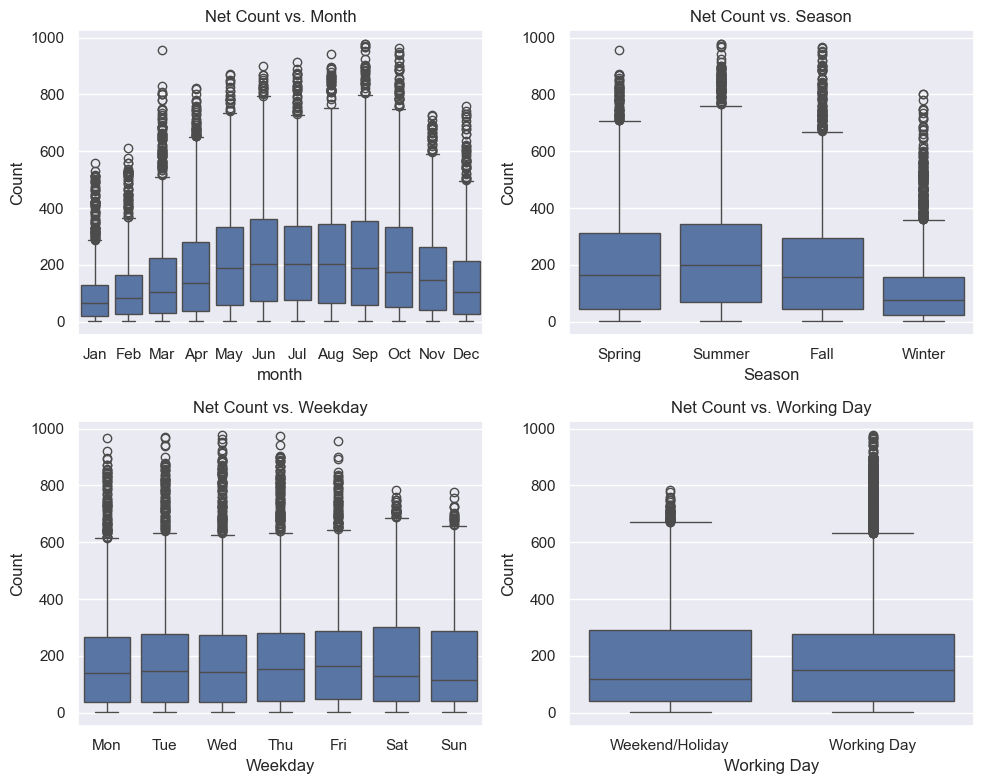

In [7]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 8)

# Define a custom order
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
season_order = ["Spring", "Summer", "Fall", "Winter"]

# Create the boxplots
sns.boxplot(data=hourly_cnt_df, y="net_cnt", x="month", orient="v", ax=axes[0][0], order=month_order)
sns.boxplot(data=hourly_cnt_df, y="net_cnt", x="season", orient="v", ax=axes[0][1], order=season_order)
sns.boxplot(data=hourly_cnt_df, y="net_cnt", x="weekday", orient="v", ax=axes[1][0], order=weekday_order)
sns.boxplot(data=hourly_cnt_df, y="net_cnt", x="workingday", orient="v", ax=axes[1][1] )

## Set labels and titles for each subplot
axes[0][0].set(ylabel='Count', title="Net Count vs. Month")
axes[0][1].set(xlabel='Season', ylabel='Count', title="Net Count vs. Season")
axes[1][0].set(xlabel='Weekday', ylabel='Count', title="Net Count vs. Weekday")
axes[1][1].set(xlabel='Working Day', ylabel='Count', title="Net Count vs. Working Day", xticklabels=['Weekend/Holiday', 'Working Day'])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

##### Observations -
1. Outliers are present across all categories.
2. Winter months have significantly lower median users than other seasons.
3. Weekend/holidays have a higher variability in user count than Weekdays.

#### Further EDA

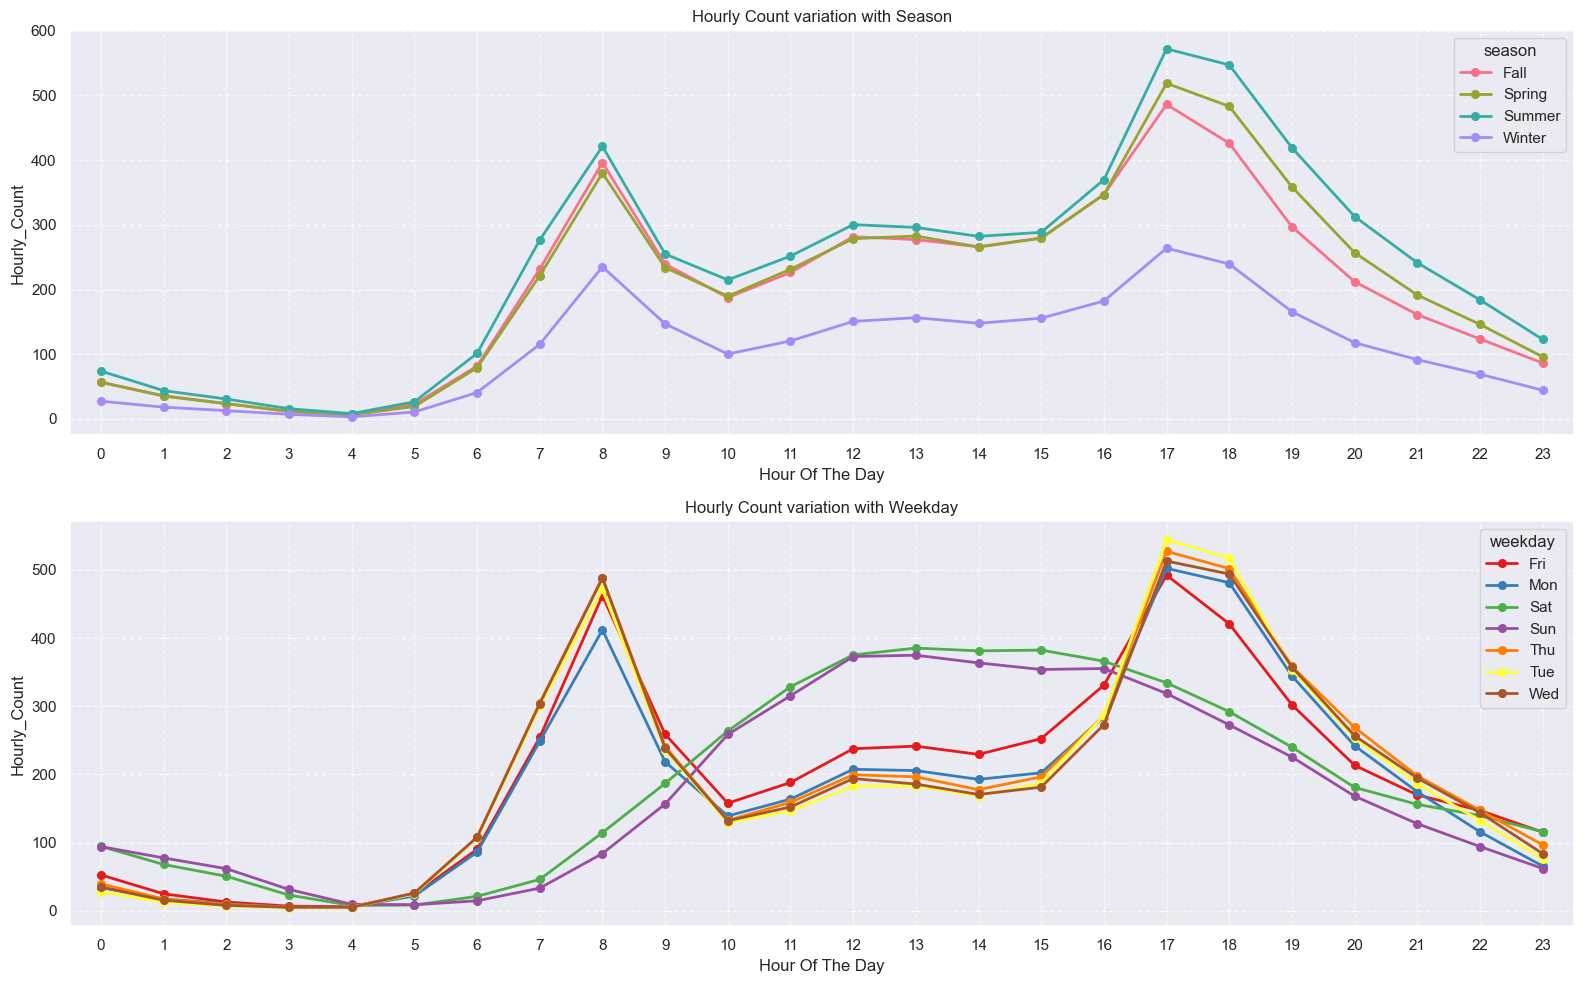

In [8]:
# Create subplots side by side
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows = 2, figsize=(16, 10))

# Define month and weekday order
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Plotting average count vs. season with different colors and adjusted line thickness
hourly_cnt_wout_df_ = pd.DataFrame(hourly_cnt_df.groupby(["hour", "season"], sort=True)["net_cnt"].mean()).reset_index()
sns.pointplot(x=hourly_cnt_wout_df_["hour"], y=hourly_cnt_wout_df_["net_cnt"], hue=hourly_cnt_wout_df_["season"], data=hourly_cnt_wout_df_, join=True, ax=ax1, palette="husl", linewidth=2)  # Change linewidth to adjust line thickness
ax1.set(xlabel='Hour Of The Day', ylabel='Hourly_Count', title="Hourly Count variation with Season", label='big')
ax1.grid(True, linestyle='--', alpha=0.7, which='both')

# Plotting average count vs. weekday with custom tick labels and adjusted line thickness
hourly_cnt_wout_df_ = pd.DataFrame(hourly_cnt_df.groupby(["hour", "weekday"], sort=True)["net_cnt"].mean()).reset_index()
sns.pointplot(x=hourly_cnt_wout_df_["hour"], y=hourly_cnt_wout_df_["net_cnt"], hue=hourly_cnt_wout_df_["weekday"], data=hourly_cnt_wout_df_, join=True, ax=ax2, palette="Set1", linewidth=2)  # Change linewidth to adjust line thickness
ax2.set(xlabel='Hour Of The Day', ylabel='Hourly_Count', title="Hourly Count variation with Weekday", label='big')
ax2.grid(True, linestyle='--', alpha=0.7, which='both')

# Adjust spacing between subplots
plt.tight_layout()

##### Visualise smoothened plot

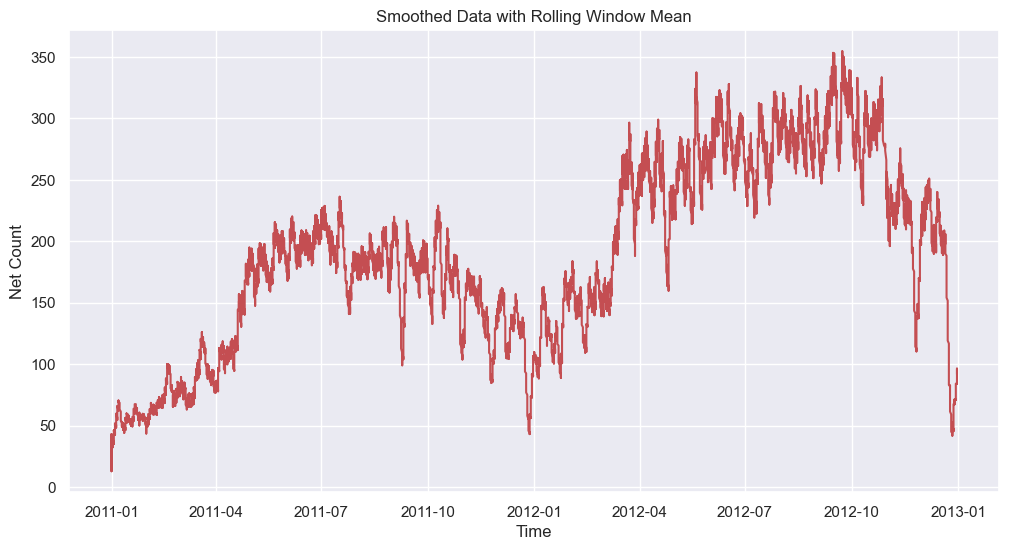

In [9]:
# Define the rolling window size
window_size = 100

# Smooth the data using rolling window mean
smoothed_data = hourly_cnt_df['net_cnt'].rolling(window=window_size, min_periods=1).mean()

# Plot the original and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(hourly_cnt_df['datetime'], smoothed_data, label='Smoothed Data', color='r')
plt.xlabel('Time')
plt.ylabel('Net Count')
plt.title('Smoothed Data with Rolling Window Mean')
plt.grid(True)
plt.show()

### § Feature Engineering

In [10]:
hourly_cnt_base_df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [11]:
def restructure_df(input_df):
    ## rename for better interpretability
    input_df.rename(columns={'dteday':'datetime',
                        'weathersit':'weather',
                        'mnth':'month',
                        'hr':'hour',
                        'yr':'year',
                        'hum':'humidity',
                        'cnt':'net_cnt'},inplace=True)

    input_df['datetime'] = pd.to_datetime(input_df['datetime'])

    ## Extract the weekdays and add 1 to convert them to the format 1-7
    input_df['DayOfWeek'] = input_df['datetime'].dt.dayofweek + 1

    ## Drop null values
    input_df.dropna(inplace=True)

    return input_df
    
hourly_cnt_train_df = restructure_df(hourly_cnt_base_df)
hourly_cnt_train_df

,instant,datetime,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,net_cnt,DayOfWeek
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,6
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,6
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,6
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,6
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,1
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,1
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,1
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,1


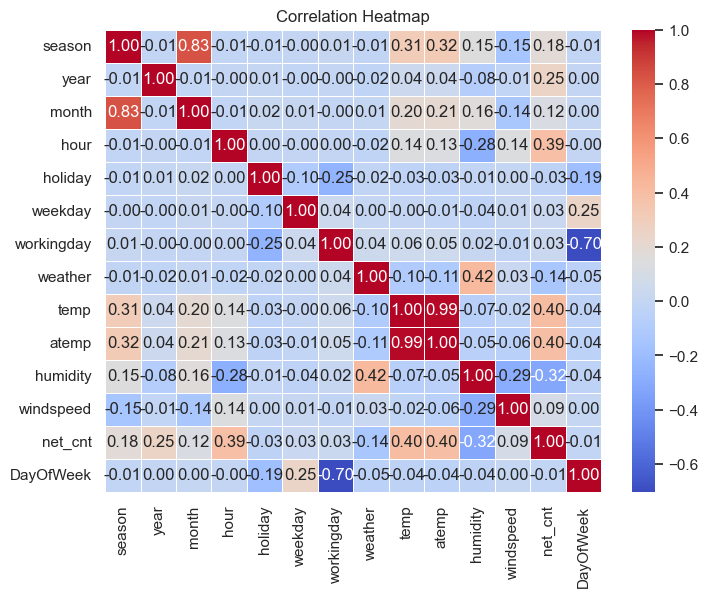

In [12]:
correlation_matrix = hourly_cnt_train_df.drop(columns=[ 'instant', 'datetime', 'casual', 'registered']).corr()
# Create a heatmap
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap")
plt.show()

In [13]:
print("correlation of bike rentals net_cnt with other fields")
print(correlation_matrix['net_cnt'].sort_values(ascending = False))

correlation of bike rentals net_cnt with other fields
net_cnt       1.000000
temp          0.404772
atemp         0.400929
hour          0.394071
year          0.250495
season        0.178056
month         0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
DayOfWeek    -0.006338
holiday      -0.030927
weather      -0.142426
humidity     -0.322911
Name: net_cnt, dtype: float64


This shows that model has a clear seasonality, however, there seems to be no trend

In [14]:
def get_rmsle(y_true, y_pre):    
    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(pd.Series(y_pre))
    squared_log_diff = (log_y_true - log_y_pred) ** 2
    mean_squared_log_error = np.mean(squared_log_diff)
    rmsle = np.sqrt(mean_squared_log_error)

    return rmsle

def custom_asymmetric_train(y_true, y_pred):
    log_a = np.log(y_true + 1)
    log_b = np.log(y_pred + 1)
    calc = (log_a - log_b) ** 2
    residual = np.sqrt(np.mean(calc))

    ## 1st grad of the loss
    grad = -2 * (log_a - log_b) / (y_pred + 1)

    ## 2nd grad of the loss
    hess = 2 / (y_pred + 1) ** 2

    return grad, hess

def custom_rmsle_valid(y_true, y_pred):
    log_y_true = np.log1p(y_true)  # Logarithm of true values
    log_y_pred = np.log1p(y_pred)  # Logarithm of predicted values
    squared_log_diff = (log_y_true - log_y_pred) ** 2
    mean_squared_log_error = np.mean(squared_log_diff)
    rmsle = np.sqrt(mean_squared_log_error)

    return "custom_rmsle_eval", rmsle, False

def read_optimal_params(output_directory, file_name):
    file_path = os.path.join(output_directory, file_name)
    hyperparameters = {}

    try:
        with open(file_path, 'r') as file:
            for line in file:
                key, value = line.strip().split(': ')
                if key in ["n_estimators", "num_leaves", "max_depth"]:
                    hyperparameters[key] = int(value)
                else:
                    hyperparameters[key] = float(value)

    except FileNotFoundError:
        print(f"File '{file_name}' not found in directory '{output_directory}'")
    
    return hyperparameters
    

In [15]:
X = hourly_cnt_train_df.drop(columns=['net_cnt', 'instant', 'datetime', 'atemp', 'casual', 'registered'])
y = hourly_cnt_train_df['net_cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)

best_params = read_optimal_params(r"data\model_params", file_name = 'best_hyperparameters.txt')
best_params

{'n_estimators': 413,
 'num_leaves': 37,
 'learning_rate': 0.08040924397296308,
 'feature_fraction': 0.7864858171788756,
 'max_depth': 13,
 'bagging_fraction': 0.980909904212945,
 'lambda_l1': 0.0001299555354247569}

In [16]:
## Train model with default params to get feature importance plot

model = lgb.LGBMRegressor()
model.set_params(**{'objective': custom_asymmetric_train}, metrics=["rmse", "mae"])
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=custom_rmsle_valid)
y_pred = model.predict(X_test)
get_rmsle(y_pred, y_test)

[LightGBM] [Info] Using self-defined objective function


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 13903, number of used features: 12
[LightGBM] [Info] Using self-defined objective function


0.37581631295546386

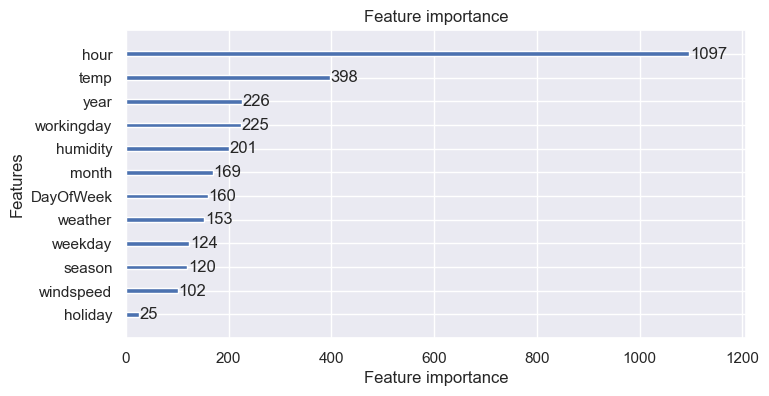

In [17]:
# Plot feature importance
lgb.plot_importance(model, figsize=(8, 4))
plt.show()

Feature importance graph shows that 'holiday' has a very little impact on prediction of the model, hence can be dropped.

##### Plot predictions and groud truth together

In [18]:
X = hourly_cnt_train_df.drop(columns=['net_cnt', 'instant', 'datetime', 'holiday', 'atemp', 'casual', 'registered'])
y = hourly_cnt_train_df['net_cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= False)

best_params = read_optimal_params(r"data\model_params", file_name = 'best_hyperparameters.txt')

model = lgb.LGBMRegressor(**best_params)
model.set_params(**{'objective': custom_asymmetric_train}, metrics=["rmse", "mae"])
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric=custom_rmsle_valid)
y_pred = model.predict(X_test)
get_rmsle(y_pred, y_test)

[LightGBM] [Warning] feature_fraction is set=0.7864858171788756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7864858171788756
[LightGBM] [Warning] lambda_l1 is set=0.0001299555354247569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001299555354247569
[LightGBM] [Warning] bagging_fraction is set=0.980909904212945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.980909904212945
[LightGBM] [Warning] feature_fraction is set=0.7864858171788756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7864858171788756
[LightGBM] [Warning] lambda_l1 is set=0.0001299555354247569, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001299555354247569
[LightGBM] [Warning] bagging_fraction is set=0.980909904212945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.980909904212945
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

0.36939637413183785

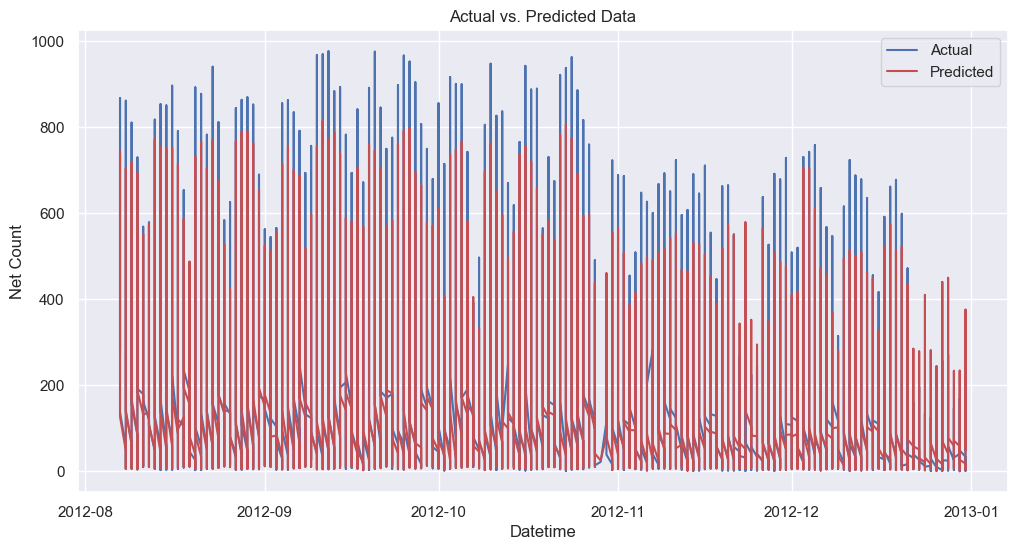

In [19]:
## Extract the 'datetime' values corresponding to the test set
test_datetime = hourly_cnt_train_df['datetime'].loc[y_test.index]

## Plot y_pred and y_test together on a single plot
plt.figure(figsize=(12, 6))
plt.plot(test_datetime, y_test, label='Actual', color='b')
plt.plot(test_datetime, y_pred, label='Predicted', color='r')
plt.xlabel('Datetime')
plt.ylabel('Net Count')
plt.title('Actual vs. Predicted Data')
plt.legend()
plt.grid(True)
plt.show()


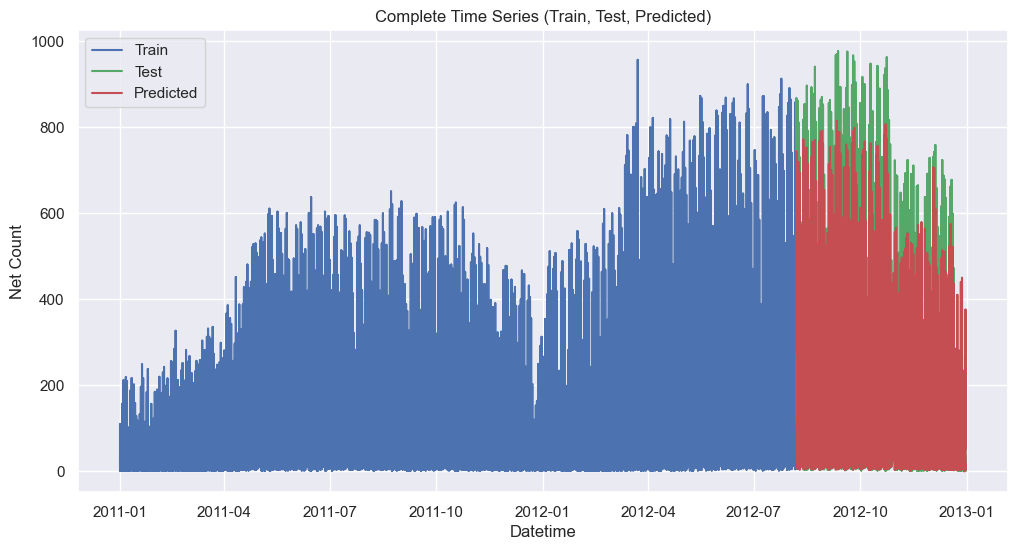

In [20]:
## Create a complete time series plot (y_train, y_test, y_pred)
complete_time_series = pd.concat([y_train, y_test, pd.Series(y_pred, index=y_test.index)], axis=1)
complete_time_series.columns = ['Train', 'Test', 'Predicted']


plt.figure(figsize=(12, 6))
plt.plot(hourly_cnt_train_df['datetime'], complete_time_series['Train'], label='Train', color='b')
plt.plot(hourly_cnt_train_df['datetime'], complete_time_series['Test'], label='Test', color='g')
plt.plot(hourly_cnt_train_df['datetime'], complete_time_series['Predicted'], label='Predicted', color='r')
plt.xlabel('Datetime')
plt.ylabel('Net Count')
plt.title('Complete Time Series (Train, Test, Predicted)')
plt.legend()
plt.grid(True)
plt.show()